In [19]:
!pip install pmdarima

^C


In [31]:
# Libraries
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [21]:
# Load/Read Data
df = pd.read_csv(r"C:\Users\kesha\Downloads\UNRATE.csv")
un_rate = df[['DATE', 'UNRATE']]
un_rate = pd.DataFrame(un_rate)

# Recast Date Variable
un_rate['DATE']=pd.to_datetime(un_rate['DATE'])

un_rate.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


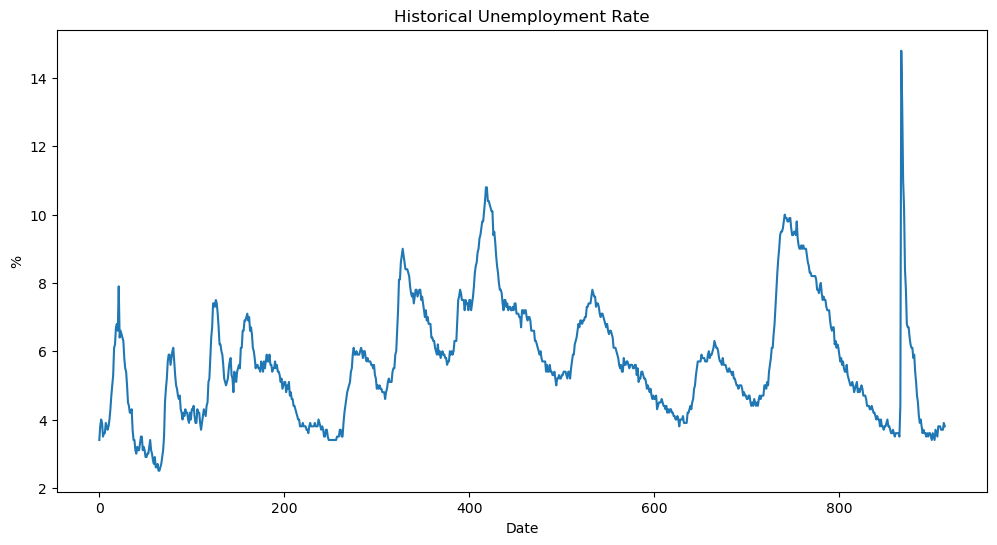

In [7]:
# Plot Data
plt.figure(figsize=(12,6))
plt.plot(un_rate['UNRATE'])
plt.title("Historical Unemployment Rate")
plt.xlabel("Date")
plt.ylabel("%")
plt.show()

In [8]:
# Create Training and Testing Data
msk = (un_rate.index < 0.7 * len(un_rate))
un_rate_train = un_rate[msk].copy()
un_rate_test = un_rate[~msk].copy()

In [9]:
# Check Stationarity
def stationarity(df):
    adf_test = adfuller(df)
    p_value = adf_test[1]
    print(f'p_value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')

stationarity(un_rate_train['UNRATE'])

# Difference
un_rate_train_diff = un_rate_train.diff().dropna()
stationarity(un_rate_train_diff['UNRATE'])

p_value: 0.09766656267407986
Non-Stationary
p_value: 1.5052519905897597e-12
Stationary


In [53]:
# Best Model Parameters with Stepwise Search
model = pm.auto_arima(un_rate_train['UNRATE'], seasonal=True, m=12, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-229.745, Time=4.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-107.742, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-129.658, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-137.155, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-109.716, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-205.407, Time=3.25 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-197.626, Time=3.14 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-229.546, Time=8.30 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-229.929, Time=8.43 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-227.697, Time=8.02 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-225.845, Time=9.14 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=-229.336, Time=8.46 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=-225.366, Time=6.85 sec
 ARIMA(3,1,2)(1,0,2)[12] intercept   : AIC=-224.174, Time=9.33 sec
 ARIMA(2,1,3)(1,0,2

In [54]:
# Model Configuration
model = SARIMAX(un_rate_train['UNRATE'], order=(1,1,2), seasonal_order=(1,0,1,12))
model_fit = model.fit()

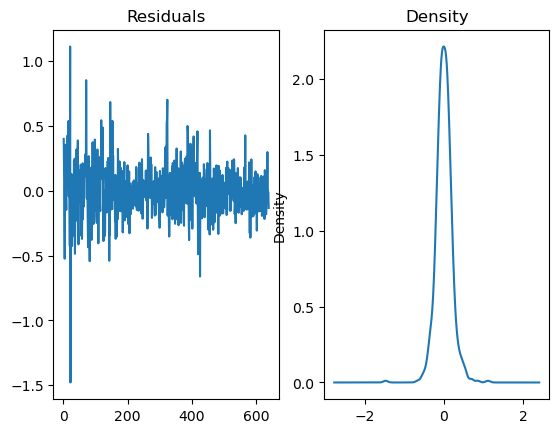

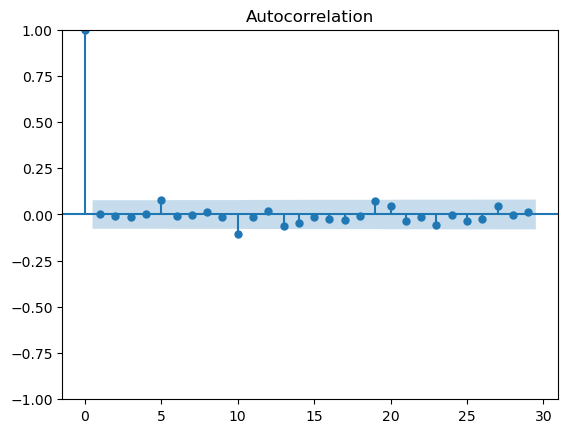

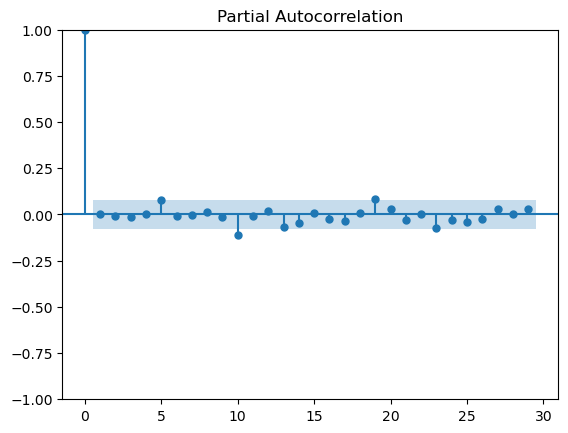

In [55]:
# Residuals
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

<Axes: >

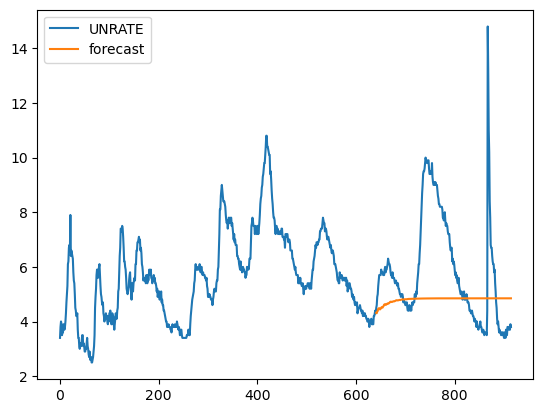

In [63]:
# Test Forecast
forecast_test = model_fit.forecast(len(un_rate_test['UNRATE']))
df['forecast'] = [None]*len(un_rate_train['UNRATE']) + list(forecast_test)
df.plot()

In [64]:
# Evaluate model predictions
mae = mean_absolute_error(un_rate_test['UNRATE'], forecast_test)
mape = mean_absolute_percentage_error(un_rate_test['UNRATE'], forecast_test)
rmse = np.sqrt(mean_squared_error(un_rate_test['UNRATE'], forecast_test))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 1.5883850758488232
mape: 0.23776555206955158
rmse: 2.2350095730162596
